# ML on ESDC using TensorFlow 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library TensorFlow. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

### Import necessary libraries
In case you experience an error due to a missing library xy, please install it via "pip install xy".

In [13]:
import datetime, os
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
from xcube.core.store import new_data_store
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

from sklearn.metrics import r2_score, mean_squared_error
import mltools as ml

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# currently not working in the jupyterhub
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

,Array,Chunk
Bytes,63.96 GiB,51.17 MiB
Shape,"(1840, 2160, 4320)","(184, 270, 270)"
Count,1281 Tasks,1280 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,63.96 GiB,51.17 MiB
Shape,"(1840, 2160, 4320)","(184, 270, 270)"
Count,1281 Tasks,1280 Chunks
Type,float32,numpy.ndarray


### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [4]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [5]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [6]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [9]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

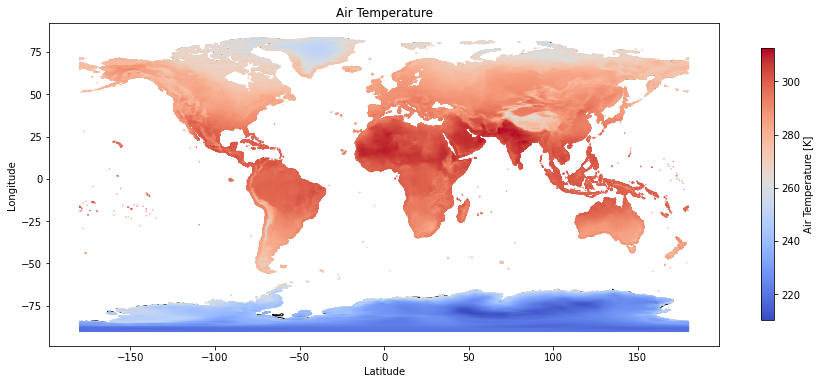

In [8]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

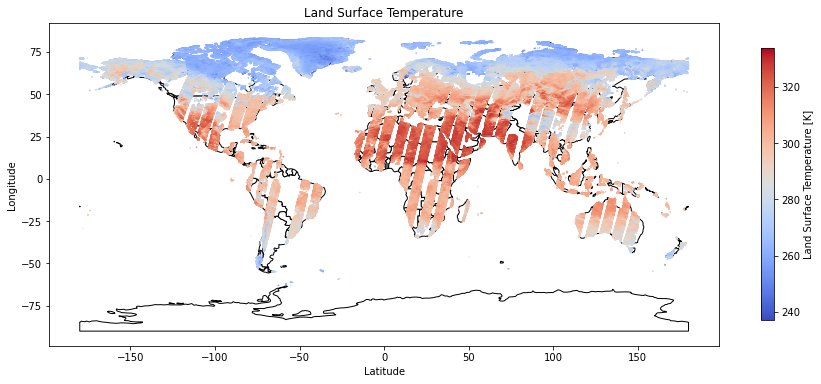

In [9]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [7]:
# random sampling
#xds = ds.assign({"split": ml.rand})


# block sampling
xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.7)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

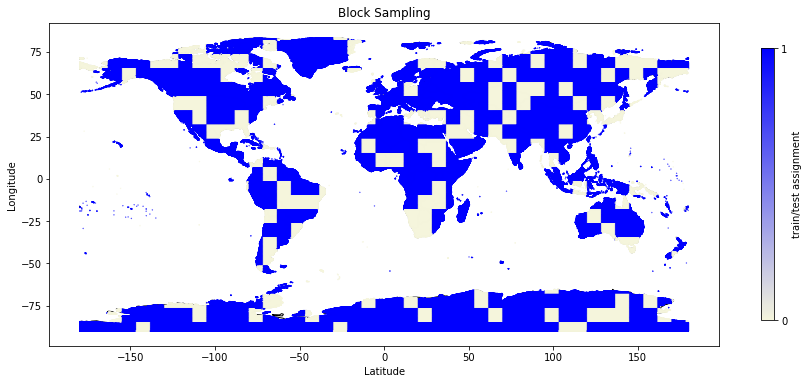

In [11]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, legend_kwds={
        "shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]}) 

plt.title('Block Sampling');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('train_test_assignment.png')

### Model set up

In [9]:
def create_model():
    inputs = L.Input(name="air_temperature_2m", shape=(1,))
    output = L.Dense(1, activation="linear", name="land_surface_temperature")(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics="mae")
    return model

model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 air_temperature_2m (InputLa  [(None, 1)]              0         
 yer)                                                            
                                                                 
 land_surface_temperature (D  (None, 1)                2         
 ense)                                                           
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [10]:
K.set_value(model.optimizer.learning_rate, 0.0001)

Enable logging for Tensorboard

In [14]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [11]:
#at_range = ml.getRange(xds, 'air_temperature_2m')
#lst_range = ml.getRange(xds, 'land_surface_temperature')

at_stat = ml.getStatistics(xds, 'air_temperature_2m')
lst_stat = ml.getStatistics(xds, 'land_surface_temperature')

### Train model

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [15]:
for chunk in ml.iter_data_var_blocks(xds): 
    ### preprocessing
    # flatten
    cf = {x: chunk[x].ravel() for x in chunk.keys()}
    # choose land values
    lm = cf['land_mask']
    cft = {x: cf[x][lm == True] for x in cf.keys()}
    # drop nans
    lst = cft['land_surface_temperature']
    cfn = {x: cft[x][~np.isnan(lst)] for x in cf.keys()}

    if len(cfn['land_surface_temperature']) > 0:
        X = ml.standardize(cfn['air_temperature_2m'],*at_stat)
        y = ml.standardize(cfn['land_surface_temperature'], *lst_stat)
        
        ### get train/test data
        X_train = X[cfn['split']==True]
        X_test  = X[cfn['split']==False]
        y_train = y[cfn['split']==True]
        y_test  = y[cfn['split']==False]
        
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        ### train model
        model.fit(train_ds.batch(100).take(10000),validation_data=test_ds.batch(100).take(2000), epochs=3, callbacks=[tensorboard_callback])

Epoch 1/3


2023-05-03 15:17:00.300457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [23402]
	 [[{{node Placeholder/_1}}]]


220/235 [===========================>..] - ETA: 0s - loss: 0.2891 - mae: 0.4294

2023-05-03 15:17:01.009686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10998]
	 [[{{node Placeholder/_1}}]]


235/235 [==============================] - 1s 2ms/step - loss: 0.2743 - mae: 0.4140 - val_loss: 0.3066 - val_mae: 0.4459
Epoch 2/3
235/235 [==============================] - 0s 2ms/step - loss: 0.2638 - mae: 0.4058 - val_loss: 0.2944 - val_mae: 0.4365
Epoch 3/3
235/235 [==============================] - 0s 2ms/step - loss: 0.2532 - mae: 0.3975 - val_loss: 0.2827 - val_mae: 0.4274
Epoch 1/3
139/789 [====>.........................] - ETA: 0s - loss: 0.3585 - mae: 0.5299

2023-05-03 15:17:02.195649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [78873]
	 [[{{node Placeholder/_1}}]]


789/789 [==============================] - 1s 1ms/step - loss: 0.2332 - mae: 0.3975
Epoch 2/3
140/789 [====>.........................] - ETA: 0s - loss: 0.3106 - mae: 0.4862

2023-05-03 15:17:03.087005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


789/789 [==============================] - 1s 1ms/step - loss: 0.2116 - mae: 0.3773
Epoch 3/3
789/789 [==============================] - 1s 1ms/step - loss: 0.1941 - mae: 0.3600
Epoch 1/3
 138/1046 [==>...........................] - ETA: 1s - loss: 0.9696 - mae: 0.9333

2023-05-03 15:17:05.080944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [104597]
	 [[{{node Placeholder/_1}}]]


1046/1046 [==============================] - 1s 1ms/step - loss: 0.3243 - mae: 0.4612 - val_loss: 0.4456 - val_mae: 0.6198
Epoch 2/3
   1/1046 [..............................] - ETA: 2s - loss: 1.1744 - mae: 1.0709

2023-05-03 15:17:06.282869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [22001]
	 [[{{node Placeholder/_1}}]]


1046/1046 [==============================] - 1s 1ms/step - loss: 0.2762 - mae: 0.4270 - val_loss: 0.3661 - val_mae: 0.5571
Epoch 3/3
1046/1046 [==============================] - 1s 1ms/step - loss: 0.2427 - mae: 0.4013 - val_loss: 0.3056 - val_mae: 0.5045
Epoch 1/3
 137/1796 [=>............................] - ETA: 1s - loss: 0.8321 - mae: 0.9062

2023-05-03 15:17:09.303604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [179559]
	 [[{{node Placeholder/_1}}]]


1796/1796 [==============================] - 2s 1ms/step - loss: 0.2537 - mae: 0.4164
Epoch 2/3
 131/1796 [=>............................] - ETA: 1s - loss: 0.5081 - mae: 0.7054

2023-05-03 15:17:11.323510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


1796/1796 [==============================] - 2s 1ms/step - loss: 0.1574 - mae: 0.3237
Epoch 3/3
1796/1796 [==============================] - 2s 1ms/step - loss: 0.1095 - mae: 0.2677
Epoch 1/3
 141/2655 [>.............................] - ETA: 2s - loss: 0.1123 - mae: 0.3036

2023-05-03 15:17:15.542763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [265442]
	 [[{{node Placeholder/_1}}]]


2655/2655 [==============================] - 3s 1ms/step - loss: 0.0724 - mae: 0.2177 - val_loss: 0.0799 - val_mae: 0.2268
Epoch 2/3
  47/2655 [..............................] - ETA: 2s - loss: 0.0516 - mae: 0.1927

2023-05-03 15:17:18.512285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16308]
	 [[{{node Placeholder/_1}}]]


2655/2655 [==============================] - 3s 1ms/step - loss: 0.0670 - mae: 0.2078 - val_loss: 0.0787 - val_mae: 0.2241
Epoch 3/3
2655/2655 [==============================] - 3s 1ms/step - loss: 0.0641 - mae: 0.2022 - val_loss: 0.0781 - val_mae: 0.2226
Epoch 1/3
135/678 [====>.........................] - ETA: 0s - loss: 0.0223 - mae: 0.1114

2023-05-03 15:17:25.011754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [67713]
	 [[{{node Placeholder/_1}}]]


640/678 [===========================>..] - ETA: 0s - loss: 0.0457 - mae: 0.1618

2023-05-03 15:17:25.782806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [234554]
	 [[{{node Placeholder/_1}}]]


678/678 [==============================] - 2s 3ms/step - loss: 0.0456 - mae: 0.1622 - val_loss: 0.0343 - val_mae: 0.1356
Epoch 2/3
678/678 [==============================] - 2s 3ms/step - loss: 0.0404 - mae: 0.1505 - val_loss: 0.0331 - val_mae: 0.1344
Epoch 3/3
678/678 [==============================] - 2s 3ms/step - loss: 0.0395 - mae: 0.1489 - val_loss: 0.0331 - val_mae: 0.1354
Epoch 1/3
 130/2845 [>.............................] - ETA: 3s - loss: 0.0616 - mae: 0.2220

2023-05-03 15:17:31.926938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [284424]
	 [[{{node Placeholder/_1}}]]


2830/2845 [============================>.] - ETA: 0s - loss: 0.0489 - mae: 0.1629

2023-05-03 15:17:35.255193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [187071]
	 [[{{node Placeholder/_1}}]]


2845/2845 [==============================] - 5s 2ms/step - loss: 0.0490 - mae: 0.1632 - val_loss: 0.0798 - val_mae: 0.2034
Epoch 2/3
2845/2845 [==============================] - 5s 2ms/step - loss: 0.0481 - mae: 0.1616 - val_loss: 0.0790 - val_mae: 0.2027
Epoch 3/3
2845/2845 [==============================] - 5s 2ms/step - loss: 0.0478 - mae: 0.1614 - val_loss: 0.0785 - val_mae: 0.2022
Epoch 1/3
129/346 [==========>...................] - ETA: 0s - loss: 0.0308 - mae: 0.1345

2023-05-03 15:17:45.967159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [34518]
	 [[{{node Placeholder/_1}}]]


346/346 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.2049 - val_loss: 0.0923 - val_mae: 0.2346
Epoch 2/3
 94/346 [=======>......................] - ETA: 0s - loss: 0.0312 - mae: 0.1381

2023-05-03 15:17:46.391018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [9072]
	 [[{{node Placeholder/_1}}]]


346/346 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.2006 - val_loss: 0.0880 - val_mae: 0.2309
Epoch 3/3
346/346 [==============================] - 0s 1ms/step - loss: 0.0666 - mae: 0.1987 - val_loss: 0.0851 - val_mae: 0.2290
Epoch 1/3
140/182 [======================>.......] - ETA: 0s - loss: 0.0638 - mae: 0.1970

2023-05-03 15:17:47.574162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [18132]
	 [[{{node Placeholder/_1}}]]
2023-05-03 15:17:47.793750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32712]
	 [[{{node Placeholder/_1}}]]


182/182 [==============================] - 0s 3ms/step - loss: 0.0726 - mae: 0.2132 - val_loss: 0.0569 - val_mae: 0.1871
Epoch 2/3
182/182 [==============================] - 0s 3ms/step - loss: 0.0724 - mae: 0.2128 - val_loss: 0.0565 - val_mae: 0.1861
Epoch 3/3
182/182 [==============================] - 0s 3ms/step - loss: 0.0722 - mae: 0.2124 - val_loss: 0.0561 - val_mae: 0.1851
Epoch 1/3
 89/131 [===================>..........] - ETA: 0s - loss: 0.0554 - mae: 0.1910

2023-05-03 15:17:49.154779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [13083]
	 [[{{node Placeholder/_1}}]]
2023-05-03 15:17:49.325268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [52494]
	 [[{{node Placeholder/_1}}]]


131/131 [==============================] - 1s 4ms/step - loss: 0.0718 - mae: 0.2189 - val_loss: 0.0627 - val_mae: 0.2015
Epoch 2/3
131/131 [==============================] - 1s 4ms/step - loss: 0.0710 - mae: 0.2164 - val_loss: 0.0627 - val_mae: 0.2015
Epoch 3/3
131/131 [==============================] - 1s 4ms/step - loss: 0.0702 - mae: 0.2141 - val_loss: 0.0627 - val_mae: 0.2015
Epoch 1/3
141/552 [======>.......................] - ETA: 0s - loss: 0.0534 - mae: 0.1880

2023-05-03 15:17:51.004465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [55159]
	 [[{{node Placeholder/_1}}]]


508/552 [==========================>...] - ETA: 0s - loss: 0.0788 - mae: 0.2256

2023-05-03 15:17:51.633882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [27175]
	 [[{{node Placeholder/_1}}]]


552/552 [==============================] - 1s 1ms/step - loss: 0.0850 - mae: 0.2319 - val_loss: 0.0401 - val_mae: 0.1596
Epoch 2/3
552/552 [==============================] - 1s 1ms/step - loss: 0.0826 - mae: 0.2267 - val_loss: 0.0368 - val_mae: 0.1513
Epoch 3/3
552/552 [==============================] - 1s 1ms/step - loss: 0.0812 - mae: 0.2232 - val_loss: 0.0348 - val_mae: 0.1460
Epoch 1/3
 133/1469 [=>............................] - ETA: 1s - loss: 0.0703 - mae: 0.2307

2023-05-03 15:17:53.682496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [146868]
	 [[{{node Placeholder/_1}}]]


1469/1469 [==============================] - 2s 1ms/step - loss: 0.0675 - mae: 0.2067 - val_loss: 0.0536 - val_mae: 0.1906
Epoch 2/3
  90/1469 [>.............................] - ETA: 1s - loss: 0.0857 - mae: 0.2582

2023-05-03 15:17:55.370065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10008]
	 [[{{node Placeholder/_1}}]]


1469/1469 [==============================] - 2s 1ms/step - loss: 0.0674 - mae: 0.2067 - val_loss: 0.0541 - val_mae: 0.1916
Epoch 3/3
1469/1469 [==============================] - 2s 1ms/step - loss: 0.0673 - mae: 0.2067 - val_loss: 0.0541 - val_mae: 0.1916
Epoch 1/3
 136/2181 [>.............................] - ETA: 2s - loss: 0.0485 - mae: 0.1732

2023-05-03 15:17:59.113713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [218047]
	 [[{{node Placeholder/_1}}]]


2170/2181 [============================>.] - ETA: 0s - loss: 0.0936 - mae: 0.2443

2023-05-03 15:18:01.575662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77643]
	 [[{{node Placeholder/_1}}]]


2181/2181 [==============================] - 3s 1ms/step - loss: 0.0935 - mae: 0.2441 - val_loss: 0.0678 - val_mae: 0.2087
Epoch 2/3
2181/2181 [==============================] - 3s 1ms/step - loss: 0.0884 - mae: 0.2378 - val_loss: 0.0685 - val_mae: 0.2101
Epoch 3/3
2181/2181 [==============================] - 3s 1ms/step - loss: 0.0869 - mae: 0.2358 - val_loss: 0.0680 - val_mae: 0.2093
Epoch 1/3
 140/1570 [=>............................] - ETA: 1s - loss: 0.0457 - mae: 0.1840

2023-05-03 15:18:08.435079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [156933]
	 [[{{node Placeholder/_1}}]]


1570/1570 [==============================] - 2s 1ms/step - loss: 0.1057 - mae: 0.2595 - val_loss: 0.0985 - val_mae: 0.2420
Epoch 2/3
  92/1570 [>.............................] - ETA: 1s - loss: 0.0329 - mae: 0.1566

2023-05-03 15:18:10.208709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4558]
	 [[{{node Placeholder/_1}}]]


1570/1570 [==============================] - 2s 1ms/step - loss: 0.0994 - mae: 0.2515 - val_loss: 0.0968 - val_mae: 0.2379
Epoch 3/3
1570/1570 [==============================] - 2s 1ms/step - loss: 0.0964 - mae: 0.2469 - val_loss: 0.0958 - val_mae: 0.2351
Epoch 1/3
120/923 [==>...........................] - ETA: 1s - loss: 0.0360 - mae: 0.1595

2023-05-03 15:18:14.018750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [92234]
	 [[{{node Placeholder/_1}}]]


896/923 [============================>.] - ETA: 0s - loss: 0.0718 - mae: 0.2044

2023-05-03 15:18:15.082448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [55295]
	 [[{{node Placeholder/_1}}]]


923/923 [==============================] - 1s 2ms/step - loss: 0.0716 - mae: 0.2049 - val_loss: 0.0804 - val_mae: 0.2139
Epoch 2/3
923/923 [==============================] - 1s 2ms/step - loss: 0.0710 - mae: 0.2045 - val_loss: 0.0799 - val_mae: 0.2135
Epoch 3/3
923/923 [==============================] - 1s 2ms/step - loss: 0.0707 - mae: 0.2042 - val_loss: 0.0796 - val_mae: 0.2131
Epoch 1/3
137/630 [=====>........................] - ETA: 0s - loss: 0.0335 - mae: 0.1474  

2023-05-03 15:18:18.596926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [62980]
	 [[{{node Placeholder/_1}}]]


630/630 [==============================] - 1s 1ms/step - loss: 0.0727 - mae: 0.2103 - val_loss: 0.0795 - val_mae: 0.2163
Epoch 2/3
 93/630 [===>..........................] - ETA: 0s - loss: 0.0332 - mae: 0.1465   

2023-05-03 15:18:19.331021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5134]
	 [[{{node Placeholder/_1}}]]


630/630 [==============================] - 1s 1ms/step - loss: 0.0707 - mae: 0.2065 - val_loss: 0.0806 - val_mae: 0.2172
Epoch 3/3
630/630 [==============================] - 1s 1ms/step - loss: 0.0695 - mae: 0.2041 - val_loss: 0.0815 - val_mae: 0.2179
Epoch 1/3
138/215 [==================>...........] - ETA: 0s - loss: 0.1250 - mae: 0.2845

2023-05-03 15:18:21.100034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [21444]
	 [[{{node Placeholder/_1}}]]


183/215 [========================>.....] - ETA: 0s - loss: 0.1252 - mae: 0.2857

2023-05-03 15:18:21.364476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [82349]
	 [[{{node Placeholder/_1}}]]


215/215 [==============================] - 1s 4ms/step - loss: 0.1199 - mae: 0.2774 - val_loss: 0.1120 - val_mae: 0.2677
Epoch 2/3
215/215 [==============================] - 1s 4ms/step - loss: 0.1153 - mae: 0.2709 - val_loss: 0.1099 - val_mae: 0.2653
Epoch 3/3
215/215 [==============================] - 1s 4ms/step - loss: 0.1118 - mae: 0.2659 - val_loss: 0.1085 - val_mae: 0.2637
Epoch 1/3
 133/1263 [==>...........................] - ETA: 1s - loss: 0.0811 - mae: 0.2267

2023-05-03 15:18:23.891684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [126234]
	 [[{{node Placeholder/_1}}]]


1253/1263 [============================>.] - ETA: 0s - loss: 0.1032 - mae: 0.2493

2023-05-03 15:18:25.342528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [103227]
	 [[{{node Placeholder/_1}}]]


1263/1263 [==============================] - 2s 2ms/step - loss: 0.1030 - mae: 0.2490 - val_loss: 0.1358 - val_mae: 0.2868
Epoch 2/3
1263/1263 [==============================] - 2s 2ms/step - loss: 0.1013 - mae: 0.2467 - val_loss: 0.1367 - val_mae: 0.2883
Epoch 3/3
1263/1263 [==============================] - 2s 2ms/step - loss: 0.1009 - mae: 0.2462 - val_loss: 0.1372 - val_mae: 0.2892
Epoch 1/3
 136/1783 [=>............................] - ETA: 1s - loss: 0.0558 - mae: 0.1830

2023-05-03 15:18:30.704288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [178209]
	 [[{{node Placeholder/_1}}]]


1783/1783 [==============================] - ETA: 0s - loss: 0.1197 - mae: 0.2624

2023-05-03 15:18:32.696735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [285233]
	 [[{{node Placeholder/_1}}]]


1783/1783 [==============================] - 3s 2ms/step - loss: 0.1197 - mae: 0.2624 - val_loss: 0.1479 - val_mae: 0.2939
Epoch 2/3
1783/1783 [==============================] - 4s 2ms/step - loss: 0.1157 - mae: 0.2576 - val_loss: 0.1428 - val_mae: 0.2887
Epoch 3/3
1783/1783 [==============================] - 3s 2ms/step - loss: 0.1148 - mae: 0.2567 - val_loss: 0.1410 - val_mae: 0.2868
Epoch 1/3
 138/5026 [..............................] - ETA: 5s - loss: 0.2039 - mae: 0.4387

2023-05-03 15:18:41.461477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [502510]
	 [[{{node Placeholder/_1}}]]


5026/5026 [==============================] - 6s 1ms/step - loss: 0.1714 - mae: 0.3117 - val_loss: 0.1129 - val_mae: 0.2626


2023-05-03 15:18:47.115481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [25658]
	 [[{{node Placeholder/_1}}]]


Epoch 2/3
5026/5026 [==============================] - 6s 1ms/step - loss: 0.1606 - mae: 0.3003 - val_loss: 0.1231 - val_mae: 0.2804
Epoch 3/3
5026/5026 [==============================] - 6s 1ms/step - loss: 0.1565 - mae: 0.2948 - val_loss: 0.1306 - val_mae: 0.2924
Epoch 1/3
 136/2128 [>.............................] - ETA: 2s - loss: 0.2332 - mae: 0.3539

2023-05-03 15:18:59.129644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [212799]
	 [[{{node Placeholder/_1}}]]


2120/2128 [============================>.] - ETA: 0s - loss: 0.1371 - mae: 0.2867

2023-05-03 15:19:01.539336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [120173]
	 [[{{node Placeholder/_1}}]]


2128/2128 [==============================] - 3s 2ms/step - loss: 0.1373 - mae: 0.2870 - val_loss: 0.1607 - val_mae: 0.3172
Epoch 2/3
2128/2128 [==============================] - 3s 2ms/step - loss: 0.1315 - mae: 0.2781 - val_loss: 0.1631 - val_mae: 0.3207
Epoch 3/3
2128/2128 [==============================] - 3s 2ms/step - loss: 0.1286 - mae: 0.2739 - val_loss: 0.1642 - val_mae: 0.3233
Epoch 1/3
 138/1259 [==>...........................] - ETA: 1s - loss: 0.0713 - mae: 0.1999

2023-05-03 15:19:09.200688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [125850]
	 [[{{node Placeholder/_1}}]]


1254/1259 [============================>.] - ETA: 0s - loss: 0.0974 - mae: 0.2346

2023-05-03 15:19:10.643422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [39260]
	 [[{{node Placeholder/_1}}]]


1259/1259 [==============================] - 2s 1ms/step - loss: 0.0981 - mae: 0.2352 - val_loss: 0.1097 - val_mae: 0.2589
Epoch 2/3
1259/1259 [==============================] - 2s 1ms/step - loss: 0.0953 - mae: 0.2305 - val_loss: 0.1097 - val_mae: 0.2603
Epoch 3/3
1259/1259 [==============================] - 2s 1ms/step - loss: 0.0943 - mae: 0.2289 - val_loss: 0.1099 - val_mae: 0.2612
Epoch 1/3
136/382 [=========>....................] - ETA: 0s - loss: 0.0773 - mae: 0.2244

2023-05-03 15:19:14.560970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [38121]
	 [[{{node Placeholder/_1}}]]


382/382 [==============================] - 1s 1ms/step - loss: 0.0723 - mae: 0.2129 - val_loss: 0.0919 - val_mae: 0.2377
Epoch 2/3
 91/382 [======>.......................] - ETA: 0s - loss: 0.0709 - mae: 0.2157

2023-05-03 15:19:15.010466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [7940]
	 [[{{node Placeholder/_1}}]]


382/382 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.2096 - val_loss: 0.0897 - val_mae: 0.2356
Epoch 3/3
382/382 [==============================] - 1s 1ms/step - loss: 0.0683 - mae: 0.2077 - val_loss: 0.0881 - val_mae: 0.2341
Epoch 1/3
134/462 [=======>......................] - ETA: 0s - loss: 0.0865 - mae: 0.2230

2023-05-03 15:19:16.264658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [46135]
	 [[{{node Placeholder/_1}}]]


462/462 [==============================] - 1s 1ms/step - loss: 0.0814 - mae: 0.2149 - val_loss: 0.0689 - val_mae: 0.1921
Epoch 2/3
 92/462 [====>.........................] - ETA: 0s - loss: 0.0675 - mae: 0.1909

2023-05-03 15:19:16.803417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [7601]
	 [[{{node Placeholder/_1}}]]


462/462 [==============================] - 1s 1ms/step - loss: 0.0811 - mae: 0.2148 - val_loss: 0.0690 - val_mae: 0.1926
Epoch 3/3
462/462 [==============================] - 1s 1ms/step - loss: 0.0809 - mae: 0.2146 - val_loss: 0.0690 - val_mae: 0.1928
Epoch 1/3
 140/2099 [=>............................] - ETA: 2s - loss: 0.2623 - mae: 0.3660

2023-05-03 15:19:18.244871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [209853]
	 [[{{node Placeholder/_1}}]]


2076/2099 [============================>.] - ETA: 0s - loss: 0.1045 - mae: 0.2356

2023-05-03 15:19:20.620273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [120578]
	 [[{{node Placeholder/_1}}]]


2099/2099 [==============================] - 3s 2ms/step - loss: 0.1040 - mae: 0.2350 - val_loss: 0.0744 - val_mae: 0.1984
Epoch 2/3
2099/2099 [==============================] - 3s 2ms/step - loss: 0.1029 - mae: 0.2364 - val_loss: 0.0742 - val_mae: 0.1988
Epoch 3/3
2099/2099 [==============================] - 3s 2ms/step - loss: 0.1027 - mae: 0.2367 - val_loss: 0.0742 - val_mae: 0.1991
Epoch 1/3
 136/5016 [..............................] - ETA: 5s - loss: 0.1786 - mae: 0.3519

2023-05-03 15:19:28.268555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [501588]
	 [[{{node Placeholder/_1}}]]


4971/5016 [============================>.] - ETA: 0s - loss: 0.1452 - mae: 0.2966

2023-05-03 15:19:33.893676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [39528]
	 [[{{node Placeholder/_1}}]]


5016/5016 [==============================] - 6s 1ms/step - loss: 0.1446 - mae: 0.2959 - val_loss: 0.1331 - val_mae: 0.2927
Epoch 2/3
5016/5016 [==============================] - 6s 1ms/step - loss: 0.1408 - mae: 0.2918 - val_loss: 0.1353 - val_mae: 0.2960
Epoch 3/3
5016/5016 [==============================] - 6s 1ms/step - loss: 0.1406 - mae: 0.2915 - val_loss: 0.1356 - val_mae: 0.2964
Epoch 1/3
 138/3654 [>.............................] - ETA: 3s - loss: 0.1130 - mae: 0.2502

2023-05-03 15:19:46.324429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [365328]
	 [[{{node Placeholder/_1}}]]


3647/3654 [============================>.] - ETA: 0s - loss: 0.1931 - mae: 0.3552

2023-05-03 15:19:50.398511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [146075]
	 [[{{node Placeholder/_1}}]]


3654/3654 [==============================] - 5s 1ms/step - loss: 0.1933 - mae: 0.3554 - val_loss: 0.1421 - val_mae: 0.2964
Epoch 2/3
3654/3654 [==============================] - 5s 1ms/step - loss: 0.1876 - mae: 0.3507 - val_loss: 0.1414 - val_mae: 0.2961
Epoch 3/3
3654/3654 [==============================] - 5s 1ms/step - loss: 0.1863 - mae: 0.3489 - val_loss: 0.1412 - val_mae: 0.2959
Epoch 1/3
 140/3580 [>.............................] - ETA: 3s - loss: 0.0569 - mae: 0.1732

2023-05-03 15:20:01.985800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [357959]
	 [[{{node Placeholder/_1}}]]


3569/3580 [============================>.] - ETA: 0s - loss: 0.1769 - mae: 0.3298

2023-05-03 15:20:06.015883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [172404]
	 [[{{node Placeholder/_1}}]]


3580/3580 [==============================] - 5s 1ms/step - loss: 0.1771 - mae: 0.3302 - val_loss: 0.1832 - val_mae: 0.3116
Epoch 2/3
3580/3580 [==============================] - 5s 1ms/step - loss: 0.1768 - mae: 0.3297 - val_loss: 0.1832 - val_mae: 0.3117
Epoch 3/3
3580/3580 [==============================] - 5s 1ms/step - loss: 0.1767 - mae: 0.3295 - val_loss: 0.1832 - val_mae: 0.3117
Epoch 1/3
 137/4742 [..............................] - ETA: 5s - loss: 0.0480 - mae: 0.1606

2023-05-03 15:20:18.033418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [474158]
	 [[{{node Placeholder/_1}}]]


4709/4742 [============================>.] - ETA: 0s - loss: 0.2375 - mae: 0.3905

2023-05-03 15:20:23.344137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [61614]
	 [[{{node Placeholder/_1}}]]


4742/4742 [==============================] - 6s 1ms/step - loss: 0.2390 - mae: 0.3920 - val_loss: 0.2855 - val_mae: 0.4200
Epoch 2/3
4742/4742 [==============================] - 6s 1ms/step - loss: 0.2393 - mae: 0.3894 - val_loss: 0.2887 - val_mae: 0.4219
Epoch 3/3
4742/4742 [==============================] - 6s 1ms/step - loss: 0.2395 - mae: 0.3889 - val_loss: 0.2891 - val_mae: 0.4221
Epoch 1/3
 138/5043 [..............................] - ETA: 5s - loss: 0.1594 - mae: 0.3209

2023-05-03 15:20:35.512891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [504221]
	 [[{{node Placeholder/_1}}]]


5043/5043 [==============================] - 6s 1ms/step - loss: 0.1401 - mae: 0.2898 - val_loss: 0.4875 - val_mae: 0.5684
Epoch 2/3
   1/5043 [..............................] - ETA: 18s - loss: 0.0296 - mae: 0.1119

2023-05-03 15:20:41.137624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [22462]
	 [[{{node Placeholder/_1}}]]


5043/5043 [==============================] - 6s 1ms/step - loss: 0.1398 - mae: 0.2896 - val_loss: 0.4969 - val_mae: 0.5759
Epoch 3/3
5043/5043 [==============================] - 6s 1ms/step - loss: 0.1385 - mae: 0.2881 - val_loss: 0.4998 - val_mae: 0.5785
Epoch 1/3
 138/2213 [>.............................] - ETA: 2s - loss: 0.1003 - mae: 0.2468

2023-05-03 15:20:52.999012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [221295]
	 [[{{node Placeholder/_1}}]]


2173/2213 [============================>.] - ETA: 0s - loss: 0.1555 - mae: 0.3179

2023-05-03 15:20:55.492847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [36696]
	 [[{{node Placeholder/_1}}]]


2213/2213 [==============================] - 3s 1ms/step - loss: 0.1534 - mae: 0.3150 - val_loss: 0.1219 - val_mae: 0.2811
Epoch 2/3
2213/2213 [==============================] - 3s 1ms/step - loss: 0.1523 - mae: 0.3137 - val_loss: 0.1198 - val_mae: 0.2782
Epoch 3/3
2213/2213 [==============================] - 3s 1ms/step - loss: 0.1519 - mae: 0.3134 - val_loss: 0.1187 - val_mae: 0.2766
Epoch 1/3
 135/1879 [=>............................] - ETA: 1s - loss: 0.0302 - mae: 0.1359

2023-05-03 15:21:01.466919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [187823]
	 [[{{node Placeholder/_1}}]]


1879/1879 [==============================] - 2s 1ms/step - loss: 0.1097 - mae: 0.2681 - val_loss: 0.1921 - val_mae: 0.3618
Epoch 2/3
  45/1879 [..............................] - ETA: 2s - loss: 0.0190 - mae: 0.1076

2023-05-03 15:21:03.585237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16559]
	 [[{{node Placeholder/_1}}]]


1879/1879 [==============================] - 2s 1ms/step - loss: 0.1046 - mae: 0.2574 - val_loss: 0.2030 - val_mae: 0.3721
Epoch 3/3
1879/1879 [==============================] - 2s 1ms/step - loss: 0.1034 - mae: 0.2540 - val_loss: 0.2075 - val_mae: 0.3765
Epoch 1/3
135/994 [===>..........................] - ETA: 0s - loss: 0.7338 - mae: 0.7642

2023-05-03 15:21:08.685846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [99397]
	 [[{{node Placeholder/_1}}]]


959/994 [===========================>..] - ETA: 0s - loss: 0.3884 - mae: 0.5199

2023-05-03 15:21:09.807200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [48725]
	 [[{{node Placeholder/_1}}]]


994/994 [==============================] - 1s 1ms/step - loss: 0.3822 - mae: 0.5147 - val_loss: 0.6007 - val_mae: 0.6874
Epoch 2/3
994/994 [==============================] - 2s 2ms/step - loss: 0.2560 - mae: 0.4055 - val_loss: 0.4666 - val_mae: 0.5906
Epoch 3/3
994/994 [==============================] - 1s 1ms/step - loss: 0.2028 - mae: 0.3559 - val_loss: 0.3871 - val_mae: 0.5275
Epoch 1/3
 134/3087 [>.............................] - ETA: 3s - loss: 0.4276 - mae: 0.5587

2023-05-03 15:21:13.360811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [308669]
	 [[{{node Placeholder/_1}}]]


3065/3087 [============================>.] - ETA: 0s - loss: 0.2313 - mae: 0.3966

2023-05-03 15:21:16.894147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [115717]
	 [[{{node Placeholder/_1}}]]


3087/3087 [==============================] - 4s 1ms/step - loss: 0.2310 - mae: 0.3963 - val_loss: 0.2094 - val_mae: 0.3695
Epoch 2/3
3087/3087 [==============================] - 4s 1ms/step - loss: 0.2301 - mae: 0.3959 - val_loss: 0.2056 - val_mae: 0.3658
Epoch 3/3
3087/3087 [==============================] - 4s 1ms/step - loss: 0.2282 - mae: 0.3946 - val_loss: 0.2039 - val_mae: 0.3643
Epoch 1/3
 136/1911 [=>............................] - ETA: 1s - loss: 0.1802 - mae: 0.3886

2023-05-03 15:21:26.661909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [191003]
	 [[{{node Placeholder/_1}}]]


1883/1911 [============================>.] - ETA: 0s - loss: 0.1510 - mae: 0.3077

2023-05-03 15:21:28.839533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [12597]
	 [[{{node Placeholder/_1}}]]


1911/1911 [==============================] - 2s 1ms/step - loss: 0.1502 - mae: 0.3072 - val_loss: 0.0873 - val_mae: 0.2200
Epoch 2/3
1911/1911 [==============================] - 2s 1ms/step - loss: 0.1014 - mae: 0.2293 - val_loss: 0.0796 - val_mae: 0.2058
Epoch 3/3
1911/1911 [==============================] - 2s 1ms/step - loss: 0.0989 - mae: 0.2241 - val_loss: 0.0832 - val_mae: 0.2111
Epoch 1/3
28/28 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2074
Epoch 2/3
28/28 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.2072
Epoch 3/3
28/28 [==============================] - 0s 2ms/step - loss: 0.0914 - mae: 0.2069


2023-05-03 15:21:33.704313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2767]
	 [[{{node Placeholder/_1}}]]
2023-05-03 15:21:33.756908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


Epoch 1/3


2023-05-03 15:21:34.049896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [16]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    0.0  
            179.708333 2002-05-21       True    0.0  
            179.791667 2002-05-21       True    0.0  
            179.875000 2002-05-21       True    0.0  
            179.958333 2002-05-21       True    0.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [17]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = model.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = ml.undo_standardizing(lstp, *at_stat)
output

54346/54346 [==============================] - 39s 709us/step


air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    0.0   
            179.708333          219.817398 2002-05-21       True    0.0   
            179.791667          219.817398 2002-05-21       True    0.0   
            179.875000          219.817398 2002-05-21       True    0.0   
            179.958333          219.817398 2002-05-21       True    0.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 253.426636  
 83.125000 -77.041667                 253.027832  
           -76.958333                 252.979370  
           -76.875000                 252.979370  
           -76.791667                 252.979370  
...                                          ...  
-89.958333  179.625000                188.781952  
            179.708333                188.781952  
            179.791667                188.781952  
            179.875000                188.781952  
            179.958333                188.781952  

[1739067 rows x 5 columns]

### Plot Predictions

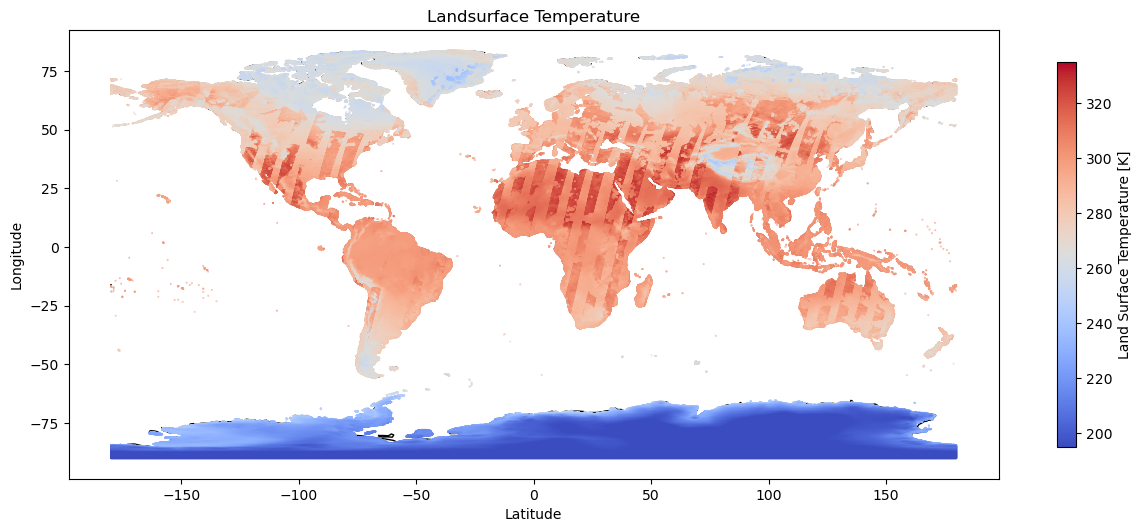

In [19]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'land_surface_temperature', cmap = 'coolwarm', vmin = 195, vmax = 335, legend = True, 
    legend_kwds={"shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()

## Launching Tensorboard UI

In [16]:
#launching tensorboard
# currently not working in the jupyterhub
%tensorboard --logdir logs